In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from utils import data_preprocessing_util as dpu
from utils import classification_util as cu

from MLP import MLP
from nn_framework import NNFramework

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Preprocessing

In [5]:
data_path = r'../Ex1/data/Breast_Cancer/breast-cancer-diagnostic.shuf.lrn.csv'
df = pd.read_csv(data_path)

In [6]:
nn = NNFramework()
nn.fit_encoder(df=df, cols_to_encode=df.columns.difference(['age', 'hours_sitting']))
df_encoded = nn.encode_dataset(df)

# Parameter experiments

## Running experiments

Define parameters:

In [7]:
random_seed = 32
log_transform = True
outlier_removal = True
scaling = True
cv_num = 5

scaler = preprocessing.StandardScaler() if scaling else None

df = dpu.preprocess_breast_cancer_data(df, log_transform=log_transform, outlier_removal=outlier_removal)

activation_functions = ['relu', 'sigmoid']
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
hidden_layer_sizes = [(5,), (32,), (16, 16), (10, 5, 5), (16, 8, 8), (64, 32, 32),]

Define train and test splits:

In [8]:
y = df['class']
X = df[df.columns.difference(['ID', 'class'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y)

Create pipelines for each parameter combination to experiment with different activation functions, learning rates, layer numbers and numbers of nodes per layer:

In [9]:
methods = []

for af in activation_functions:
    for lr in learning_rates:
        for hls in hidden_layer_sizes:
            methods.append((f'MLP-{af}-{lr}-{hls}', MLP(n_iter=5000, activation_function=af, learning_rate=lr, hidden_layer_sizes=hls)))
    
pipelines = cu.define_pipelines(methods, scaler=scaler)

Run the experiments, save the experiment results to csv and pickle:

In [245]:
# models, model_params, model_lists = cu.run_cv_experiments(pipelines, X, y, cv_num, scoring='f1_macro', n_jobs=10, print_output=False)

df_param = pd.DataFrame(model_params).transpose()
df_param = df_param.reset_index(drop=False)
df_param = df_param.rename(columns={'index': 'model'})

for c in df_param.columns:
    if ('_num' in c) or ('_std' in c) or ('_mean' in c):
        df_param[c] = df_param[c].astype(float)

# for c in df_param.columns:
#     if ('_num' in c) or ('_std' in c) or ('_mean' in c):
#         df_param[c] = df_param[c].astype(float)

# df_param.to_csv(r'results/breast_params_experiments.csv', index=False)

# with open(r'results/breast_lists_experiments.pickle', 'wb') as handle:
#     pickle.dump(model_lists, handle, protocol=pickle.HIGHEST_PROTOCOL)

Train 5 models with 5 parameter combinations which showed the best f1 scores on the full train split. Evaluate their performance with a number of different metrics and save the results to another df:

In [11]:
results_df = pd.DataFrame()

best_model_names = df_param.sort_values(['test_score_mean'], ascending=False).head(5)['model']
for best_model_name in best_model_names:
    pipelines[best_model_name].fit(X_train, y_train)
    y_pred = pipelines[best_model_name].predict(X_test)
    eval_results = cu.eval(y_pred, y_test)

    results_df = results_df.append({
        'model': best_model_name,
        'cm': eval_results['cm'].flatten(),
        'acc': eval_results['acc'],
        'balanced_acc': eval_results['balanced_acc'],
        'precision': eval_results['precision'],
        'recall': eval_results['recall'],
        'f-score': eval_results['f-score'],
        'support': eval_results['support']
    }, ignore_index=True)

results_df.to_csv("results/breast_cancer_5_best_trainset.csv", index=False)

Loss did not go down for 10 iterations. Stopping training at iteration 26...
Evaluation metrics:


array([[1.        , 0.        ],
       [0.11764706, 0.88235294]])

acc: 0.96
balanced_acc: 0.9411764705882353

Macro-averaged precision: 0.9714285714285714
Macro-averaged recall: 0.9411764705882353
Macro-averaged f-score: 0.9540441176470589
Macro-averaged support: None


C:\Users\Alina\AppData\Local\Temp\ipykernel_2280\1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 43...
Evaluation metrics:


array([[0.96969697, 0.03030303],
       [0.05882353, 0.94117647]])

acc: 0.96
balanced_acc: 0.9554367201426025

Macro-averaged precision: 0.9554367201426025
Macro-averaged recall: 0.9554367201426025
Macro-averaged f-score: 0.9554367201426025
Macro-averaged support: None


C:\Users\Alina\AppData\Local\Temp\ipykernel_2280\1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 46...
Evaluation metrics:


array([[0.96969697, 0.03030303],
       [0.11764706, 0.88235294]])

acc: 0.94
balanced_acc: 0.9260249554367201

Macro-averaged precision: 0.9393382352941176
Macro-averaged recall: 0.9260249554367201
Macro-averaged f-score: 0.9321573948439621
Macro-averaged support: None


C:\Users\Alina\AppData\Local\Temp\ipykernel_2280\1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 114...
Evaluation metrics:


array([[1.        , 0.        ],
       [0.05882353, 0.94117647]])

acc: 0.98
balanced_acc: 0.9705882352941176

Macro-averaged precision: 0.9852941176470589
Macro-averaged recall: 0.9705882352941176
Macro-averaged f-score: 0.9773857982813207
Macro-averaged support: None


C:\Users\Alina\AppData\Local\Temp\ipykernel_2280\1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 51...
Evaluation metrics:


array([[0.96969697, 0.03030303],
       [0.05882353, 0.94117647]])

acc: 0.96
balanced_acc: 0.9554367201426025

Macro-averaged precision: 0.9554367201426025
Macro-averaged recall: 0.9554367201426025
Macro-averaged f-score: 0.9554367201426025
Macro-averaged support: None


C:\Users\Alina\AppData\Local\Temp\ipykernel_2280\1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


## Analysis

In [246]:
model_lists_df = pd.DataFrame(model_lists).transpose()
model_lists_df = model_lists_df.reset_index(drop=False)
model_lists_df = model_lists_df.rename(columns={'index': 'model'})

model_lists_df['converged_num'] = model_lists_df.converged.apply(lambda x: sum(x))
model_lists_df['diverged'] = 5 - model_lists_df['converged_num']

model_lists_df['activation_function'] = model_lists_df.model.str.extract(r'MLP-(\w+)-.*')
model_lists_df['learning_rate'] = model_lists_df.model.str.extract(r'.*-([\d|.]+)-.*').astype(float)
model_lists_df['hidden_layer_sizes'] = model_lists_df.model.str.extract(r'MLP-.*-.*-(.*)')

accuracy_threshold = df_param['test_score_mean'].max() * 0.5

In [247]:
for c in model_lists_df.columns.difference(['model', 'activation_function', 'learning_rate', 'hidden_layer_sizes', 'converged_num', 'diverged']):
    for i in range(cv_num):
        model_lists_df[f'{c}_cv{i}'] = model_lists_df[c].apply(lambda x: x[i])

In [ ]:
for i in range(5):
    model_lists_df[f'vanishing_gradients_cv{i}'] = False
    model_lists_df.loc[model_lists_df[f'converged_cv{i}'] & (model_lists_df[f'test_score_cv{i}'] < accuracy_threshold), f'vanishing_gradients_cv{i}'] = True

vg_cols = [c for c in model_lists_df.columns if 'vanishing_gradients_' in c]
model_lists_df[f'vanishing_gradients'] = pd.Series(model_lists_df[vg_cols].values.tolist())
model_lists_df[f'vanishing_gradients'] = model_lists_df[f'vanishing_gradients'].apply(lambda x: sum(x))

In [248]:
model_lists_df['all_converged'] = model_lists_df.converged.apply(lambda x: all(x))
model_lists_df['any_converged'] = model_lists_df.converged.apply(lambda x: any(x))

In [249]:
df_param = df_param.merge(model_lists_df[['model', 'all_converged', 'any_converged']], on='model', how='left')

In [475]:
max_accuracies_ids = df_param[df_param.any_converged].groupby(['hidden_layer_sizes', 'activation_function'])['test_score_mean'].idxmax()
max_accuracies_models = df_param.iloc[max_accuracies_ids.values, :]

In [252]:
id_vars = model_lists_df.columns.difference(list([c for c in model_lists_df.columns if '_cv' in c]))
model_lists_melted_df = model_lists_df.melt(id_vars=id_vars, var_name = 'metric_name', value_name='metric_value')

In [ ]:
color = [(127,201,127),(190,174,212),(253,192,134),(56,108,176),(255,255,153)]
for i, rgb in enumerate(color):
    r, g, b = rgb
    color[i] = r/255.0, g/255.0, b/255.0

from matplotlib.colors import ListedColormap
cmap = ListedColormap([color[3], color[2]])

### Sigmoid vs RELU

In [467]:
def get_specific_table(model_lists_melted_df, col, accuracy_threshold):
    df = model_lists_melted_df[model_lists_melted_df.metric_name.str.contains(col)].copy()
    df['model_short'] = df['model'].str.replace('-sigmoid-', '-').str.replace('-relu-', '-')
    df = df.sort_values(by='converged')

    df.loc[:, 'cv'] = df.metric_name.str.extract(r'.*_cv(\d)').astype(int)
    df.loc[:, 'test_score_cv'] = df.apply(lambda x: x.test_score[x.cv], axis=1)
    df.loc[:, 'converged_cv'] = df.apply(lambda x: x.converged[x.cv], axis=1)

    df = df[(df.test_score_cv > accuracy_threshold) & df.converged_cv].copy()

    both_models_converged = pd.DataFrame(df.groupby(['model_short']).activation_function.nunique())
    both_models_converged = both_models_converged.reset_index(drop=False)
    both_models_converged.columns = ['model_short', 'num_models_converged']

    df = df.merge(both_models_converged, on='model_short', how='left')

    return df

#### Fitting times

In [468]:
df_fit_times = get_specific_table(model_lists_melted_df, col='fit_time', accuracy_threshold=accuracy_threshold)

[Text(0.5, 1.0, 'Mean fitting times over converged models'),
 Text(0.5, 0, 'fitting times (s)'),
 Text(0, 0.5, 'model')]

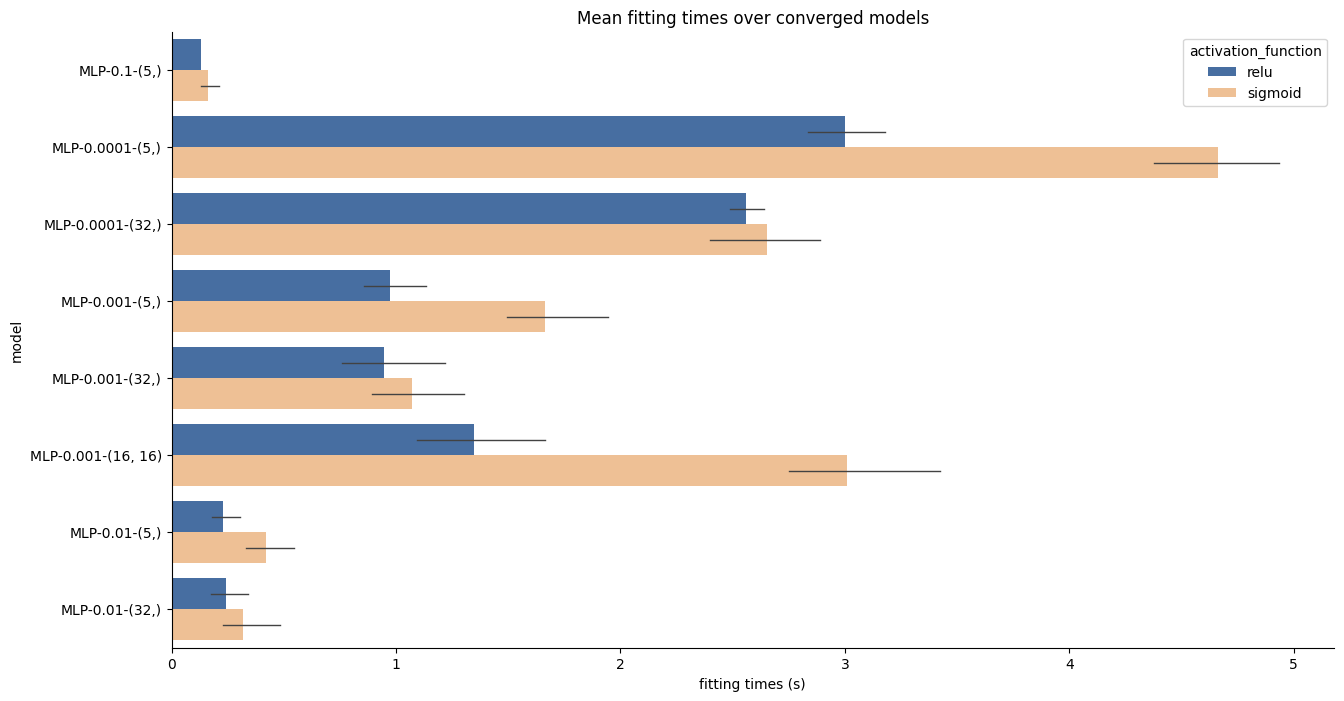

In [530]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
sns.barplot(data=df_fit_times[df_fit_times.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1, palette=[color[3], color[2]])
ax.set(title='Mean fitting times over converged models', xlabel='fitting times (s)', ylabel='model')

In [491]:
max_accuracies_models.model.unique()

array(['MLP-relu-0.01-(5,)', 'MLP-sigmoid-0.01-(5,)',
       'MLP-relu-0.001-(10, 5, 5)', 'MLP-sigmoid-0.01-(10, 5, 5)',
       'MLP-relu-0.001-(16, 8, 8)', 'MLP-sigmoid-0.01-(16, 8, 8)',
       'MLP-relu-0.001-(16, 16)', 'MLP-sigmoid-0.01-(16, 16)',
       'MLP-relu-0.01-(32,)', 'MLP-sigmoid-0.01-(32,)',
       'MLP-relu-0.0001-(64, 32, 32)', 'MLP-sigmoid-0.1-(64, 32, 32)'],
      dtype=object)

[Text(0.5, 1.0, 'Mean fitting times for best hidden layer size combination'),
 Text(0.5, 0, 'fitting times (s)'),
 Text(0, 0.5, 'layer size')]

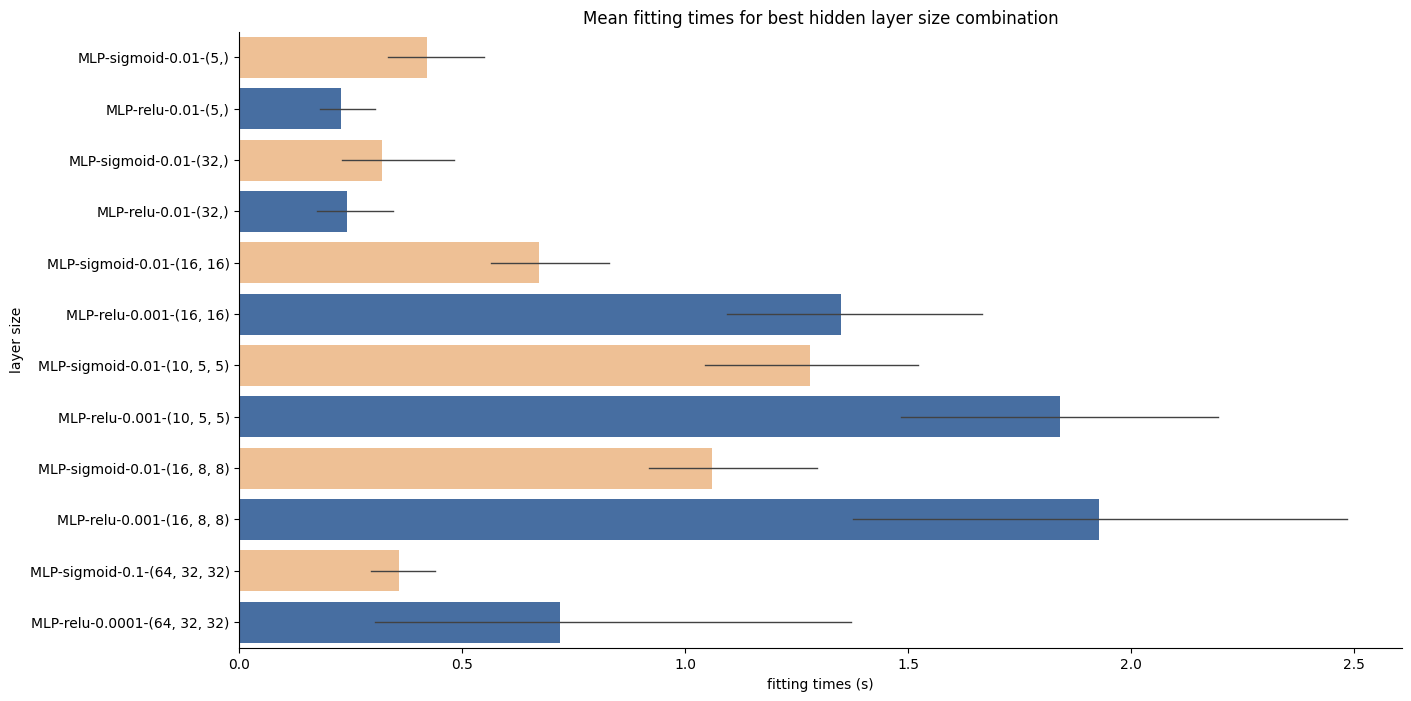

In [524]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
df_fit_times_sorted = df_fit_times[df_fit_times.model.isin(max_accuracies_models.model.unique())].copy()
df_fit_times_sorted['s2'] = df_fit_times_sorted['activation_function'].apply(lambda x: 1 if x == 'sigmoid' else 2)
df_fit_times_sorted['s3'] = df_fit_times_sorted['hidden_layer_sizes'].apply(lambda x: x)
df_fit_times_sorted['s1'] = df_fit_times_sorted['hidden_layer_sizes'].apply(lambda x: len(x))
df_fit_times_sorted = df_fit_times_sorted.sort_values(by=['s1', 's3', 's2'])
colors = [color[2], color[3]] * 6
ax = sns.barplot(data=df_fit_times_sorted, y='model', x='metric_value', ax=ax, errwidth=1, palette = colors)
ax.set(title=f'Mean fitting times for best hidden layer size combination', xlabel='fitting times (s)', ylabel='layer size')

#### Performance

In [481]:
df_test_scores = get_specific_table(model_lists_melted_df, col='test_score', accuracy_threshold=accuracy_threshold)

[Text(0.5, 1.0, 'Mean f1 scores over converged models'),
 Text(0.5, 0, 'f1 score'),
 Text(0, 0.5, 'model')]

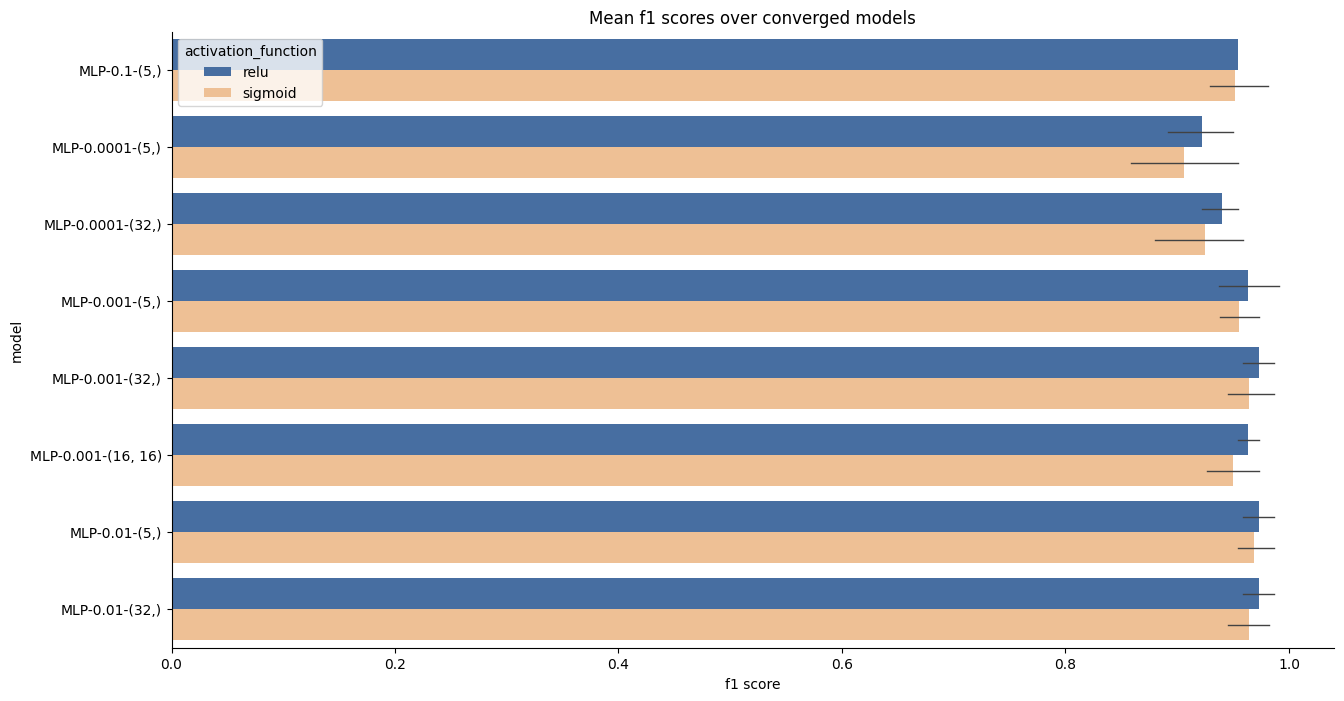

In [529]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
sns.barplot(data=df_test_scores[df_test_scores.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1, palette=[color[3], color[2]])
ax.set(title='Mean f1 scores over converged models', xlabel='f1 score', ylabel='model')

[Text(0.5, 1.0, 'Mean f scores for best hidden layer size combination'),
 Text(0.5, 0, 'fitting times (s)'),
 Text(0, 0.5, 'layer size')]

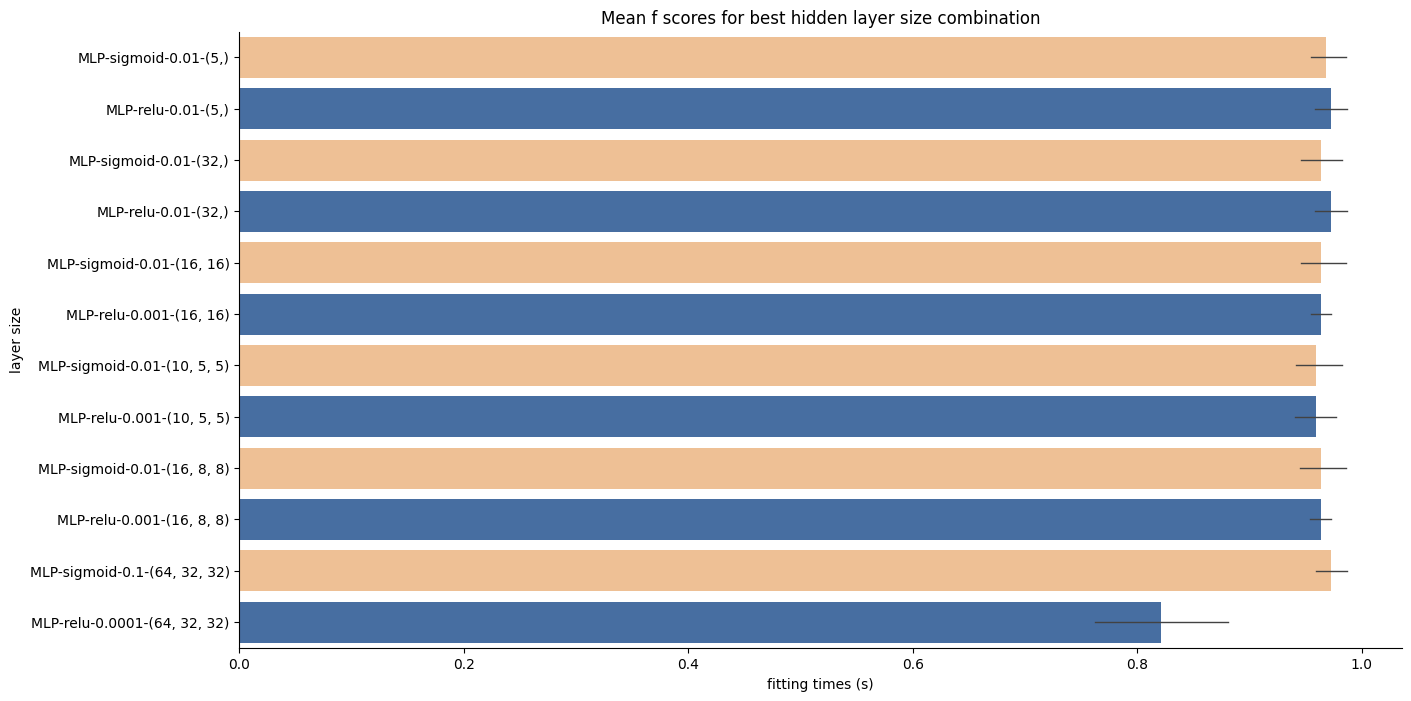

In [526]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
df_test_scores_sorted = df_test_scores[df_test_scores.model.isin(max_accuracies_models.model.unique())].copy()
df_test_scores_sorted['s2'] = df_test_scores_sorted['activation_function'].apply(lambda x: 1 if x == 'sigmoid' else 2)
df_test_scores_sorted['s3'] = df_test_scores_sorted['hidden_layer_sizes'].apply(lambda x: x)
df_test_scores_sorted['s1'] = df_test_scores_sorted['hidden_layer_sizes'].apply(lambda x: len(x))
df_test_scores_sorted = df_test_scores_sorted.sort_values(by=['s1', 's3', 's2'])
colors = [color[2], color[3]] * 6
ax = sns.barplot(data=df_test_scores_sorted, y='model', x='metric_value', ax=ax, errwidth=1, palette = colors)
ax.set(title=f'Mean f scores for best hidden layer size combination', xlabel='fitting times (s)', ylabel='layer size')

#### Convergence and vanishing gradients

Looking at gradients where accuracy is bad although training was not interrupted:

In [263]:
model_lists_df[model_lists_df[f'vanishing_gradients'] > 0]

,model,test_score,fit_time,score_time,converged,validation_losses,training_losses,gradients,converged_num,diverged,...,validation_losses_cv3,validation_losses_cv4,all_converged,any_converged,vanishing_gradients_cv0,vanishing_gradients_cv1,vanishing_gradients_cv2,vanishing_gradients_cv3,vanishing_gradients_cv4,vanishing_gradients
58,"MLP-sigmoid-0.5-(16, 8, 8)","[0.9540441176470589, 1.0, 0.9560931899641577, ...","[0.2600579261779785, 0.2850637435913086, 0.309...","[0.002000570297241211, 0.002001047134399414, 0...","[True, True, True, True, True]","[[0.4901331484908564, 0.24383595892266094, 0.2...","[[0.17756503908562082, 0.01822907580963325, 0....","[{0: [-6.023924570524429e-19, -3.2722755998374...",5,0,...,"[2.5098757000513956, 2.5433728534686724, 2.547...","[2.5036554061900693, 2.537604966110174, 2.5456...",True,True,False,False,False,False,True,1
59,"MLP-sigmoid-0.5-(64, 32, 32)","[0.2537313432835821, 0.25757575757575757, 0.25...","[0.26313185691833496, 0.2691457271575928, 0.26...","[0.0020155906677246094, 0.003000497817993164, ...","[True, True, True, True, True]","[[12.52219761119377, 12.714935800504529, 12.81...","[[12.5963020938545, 12.790184091258494, 12.893...","[{0: [-1.0950247471146218e-18, -1.721209989690...",5,0,...,"[11.57539104287702, 11.658063360864583, 11.704...","[11.590728767816604, 11.682294233678544, 11.73...",True,True,True,True,True,True,True,5


In [380]:
g_id = 58
i = 4
gradients = model_lists_df.loc[g_id, 'gradients'][i]

model             MLP-sigmoid-0.5-(16, 8, 8)
test_score_cv4                      0.257576
Name: 58, dtype: object

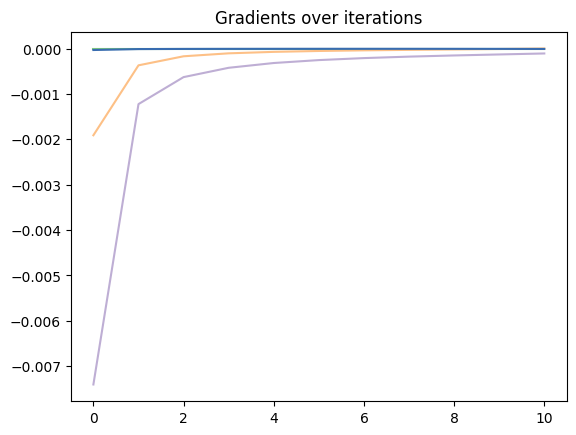

In [538]:
for i, grad in gradients.items():
    ax = sns.lineplot(x=range(len(grad)), y=grad, color=color[i])
    ax.set_title(f'Gradients over iterations')

<Axes: >

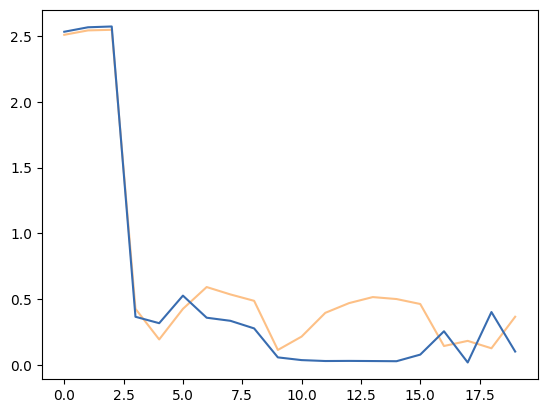

In [533]:
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'validation_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'validation_losses_cv{i}'], color=color[2])
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'training_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'training_losses_cv{i}'], color=color[3])

C:\Users\Alina\AppData\Local\Temp\ipykernel_2280\3978959023.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  failure_count = model_lists_df.groupby(['learning_rate'])['diverged', 'vanishing_gradients'].sum() / (12 * 5)


<Axes: xlabel='learning_rate'>

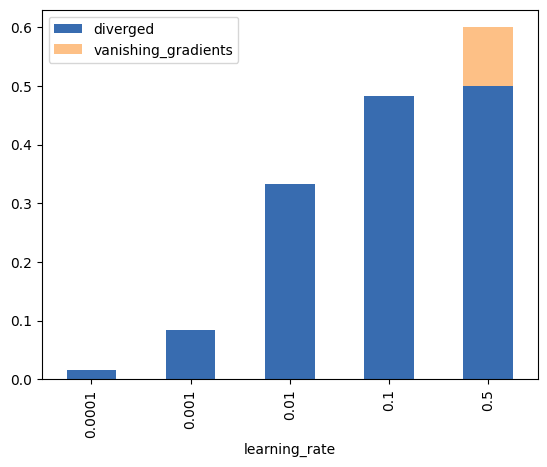

In [333]:
failure_count = model_lists_df.groupby(['learning_rate'])['diverged', 'vanishing_gradients'].sum() / (12 * 5)
failure_count.plot(kind='bar', stacked=True, cmap=cmap)

In [300]:
def get_failure_df(model_lists_df, by_col='hidden_layer_sizes'):
    failure_count = model_lists_df.groupby([by_col])['diverged', 'vanishing_gradients'].sum() / (12 * 5)
    failure_count = failure_count.reset_index(drop=False)
    failure_count['layer_size_len'] = failure_count[by_col].apply(lambda x: len(x))
    failure_count = failure_count.sort_values(by='layer_size_len')
    failure_count = failure_count.drop('layer_size_len', axis=1)
    failure_count = failure_count.set_index(by_col)
    return failure_count

C:\Users\Alina\AppData\Local\Temp\ipykernel_2280\3839886018.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  failure_count = model_lists_df.groupby([by_col])['diverged', 'vanishing_gradients'].sum() / (12 * 5)


<Axes: xlabel='hidden_layer_sizes'>

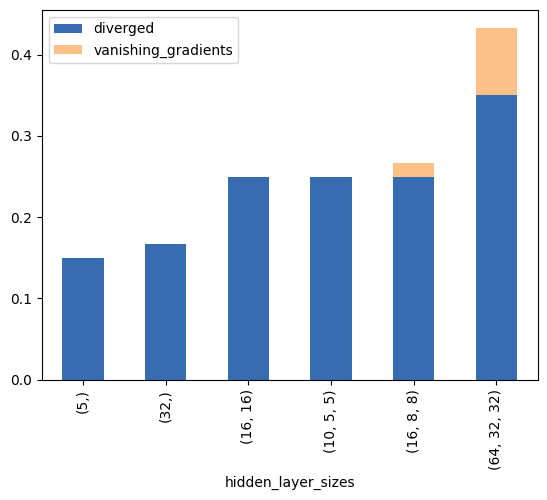

In [331]:
failure_count = get_failure_df(model_lists_df, by_col='hidden_layer_sizes')
failure_count.plot(kind='bar', stacked=True, colormap=cmap)